# ElasticAST evaluated on VGGSound
All the evaluation logs can be observed below.

When doing it your self, please change the directory accordingly.

NOTE: VGGSound is a fixed-length dataset, and the experiments are used to measure the performance for **various resolution**.

## Create and load the model

In [1]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from tqdm import tqdm


from models import ElasticAST
import numpy as nps
from utilities import *


batch_size = 12
mel_bins = 128
audio_length = 1024
dataset = 'vggsound'
dataset_mean = -5.08
dataset_std = 4.453
Fshift = 10
window_size = 25
data_val = '/home/jfeng/FJ/ElasticAST/egs/vggsound/data/datafiles/vgg_final_test.json'
label_csv = '/home/jfeng/FJ/ElasticAST/egs/vggsound/data/class_labels_indices.csv'
expand_ratio=1

# Model, Loss, and Optimizer
model = ElasticAST(
    sample_size = (mel_bins,int(audio_length/expand_ratio)),
    patch_size = 16,
    num_classes = 309,
    dim = 768,
    depth = 12,
    heads = 12,
    dropout = 0,
    emb_dropout = 0,
    token_dropout_prob = 0,  # token dropout of 10% (keep 90% of tokens)
    channels=1,
)


model_load = "/home/jfeng/FJ/ElasticAST/pretrain_weights/ElasctiAST_VGGSound.pth"


out_dict = {}
state_dict = torch.load(model_load,map_location=torch.device('cpu'))
for k, v in state_dict.items(): # Adjust the name of dict
    out_dict[k[7:]] = v
model.load_state_dict(out_dict, strict=True)

/home/jfeng/anaconda3/envs/flexiast2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

## Prepare for the datasets and evaluation pipelines.

In [2]:
import dataloader

val_audio_conf = {'num_mel_bins': mel_bins, 'target_length': audio_length, 'freqm': 0, 'timem': 0, 'mixup': 0,
                'dataset': dataset, 'mode': 'evaluation', 'mean': dataset_mean, 'std': dataset_std, 'noise': False,
                'Fshift': Fshift,"window_size":window_size}

quality_ratio = np.arange(1, 4.2, 0.2)

quality_acc = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for q in quality_ratio:
    q = round(q, 2)
    val_loader = torch.utils.data.DataLoader(
    dataloader.ElasticQuality_Dataset(data_val, label_csv=label_csv, audio_conf=val_audio_conf,quality_ratio=[q]),
    batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True,collate_fn=dataloader.list_collate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        if not isinstance(model, nn.DataParallel):
            model = nn.DataParallel(model)
        A_predictions = []
        A_targets = []
        with tqdm(val_loader) as vepoch:
            for data_items, labels in vepoch:
                data_items, labels = data_items, labels
                for i in range(len(data_items)):
                    data_items[i] = data_items[i].to(device)

                # max_seq_len=2048
                max_seq_len=int(1024/q)
                outputs = model(data_items,group_samples=True,group_max_seq_len=max_seq_len)
                outputs = torch.sigmoid(outputs)
                predictions = outputs.to('cpu').detach()

                A_predictions.append(predictions)
                A_targets.append(labels)

                labels = labels.to(device)

        outputs = torch.cat(A_predictions)
        labels = torch.cat(A_targets)
        stats = calculate_stats(outputs, labels)

    mAP = np.mean([stat['AP'] for stat in stats])
    acc = stats[0]['acc']
    print(f"Mel-spec resolution is compressed {q} times, mAP: {mAP}, acc: {acc}")
    quality_acc.append(acc)

print(quality_acc)

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [01:03<00:00, 20.22it/s]


Mel-spec resolution is compressed 1.0 times, mAP: 0.5418472111422491, acc: 0.5244076136216497
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:46<00:00, 27.42it/s]


Mel-spec resolution is compressed 1.2 times, mAP: 0.5423908153676537, acc: 0.5269972808494109
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:41<00:00, 31.07it/s]


Mel-spec resolution is compressed 1.4 times, mAP: 0.5381054770252237, acc: 0.5234364884112391
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:34<00:00, 37.72it/s]


Mel-spec resolution is compressed 1.6 times, mAP: 0.5384930610394695, acc: 0.5239544218567914
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:30<00:00, 42.34it/s]


Mel-spec resolution is compressed 1.8 times, mAP: 0.5340626908565099, acc: 0.5174802537873883
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:26<00:00, 48.51it/s]


Mel-spec resolution is compressed 2.0 times, mAP: 0.53243904606959, acc: 0.5151495532824032
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:26<00:00, 49.10it/s]


Mel-spec resolution is compressed 2.2 times, mAP: 0.5307271761010185, acc: 0.5160559368121197
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:22<00:00, 56.54it/s]


Mel-spec resolution is compressed 2.4 times, mAP: 0.5256464589364953, acc: 0.5102291855496569
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:23<00:00, 55.56it/s]


Mel-spec resolution is compressed 2.6 times, mAP: 0.5239723901759679, acc: 0.5074452932798136
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:23<00:00, 55.79it/s]


Mel-spec resolution is compressed 2.8 times, mAP: 0.5201671016444754, acc: 0.5037550174802538
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:20<00:00, 62.42it/s]


Mel-spec resolution is compressed 3.0 times, mAP: 0.5189766619834243, acc: 0.504143467564418
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:22<00:00, 57.58it/s]


Mel-spec resolution is compressed 3.2 times, mAP: 0.5198822908390224, acc: 0.5030428589926195
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:22<00:00, 58.16it/s]


Mel-spec resolution is compressed 3.4 times, mAP: 0.5107649723527983, acc: 0.4953385989900298
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:20<00:00, 62.46it/s]


Mel-spec resolution is compressed 3.6 times, mAP: 0.504031482779413, acc: 0.49294315680435064
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:21<00:00, 59.77it/s]


Mel-spec resolution is compressed 3.8 times, mAP: 0.5013848298012347, acc: 0.4880875307522983
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process vggsound
use dataset mean -5.080 and std 4.453 to normalize the input.
number of classes is 309
now using frame shift 10
now using win size 25
changing window size:  None


100%|██████████| 1288/1288 [00:20<00:00, 63.67it/s]


Mel-spec resolution is compressed 4.0 times, mAP: 0.5004516561446459, acc: 0.48601579697008934
[0.5244076136216497, 0.5269972808494109, 0.5234364884112391, 0.5239544218567914, 0.5174802537873883, 0.5151495532824032, 0.5160559368121197, 0.5102291855496569, 0.5074452932798136, 0.5037550174802538, 0.504143467564418, 0.5030428589926195, 0.4953385989900298, 0.49294315680435064, 0.4880875307522983, 0.48601579697008934]


In [3]:
import numpy as np
quality_ratio = np.arange(1, 4.2, 0.2)


In [4]:
# What we obtained above is:
elastic_ast = [0.5244076136216497, 0.5269972808494109, 0.5234364884112391, 0.5239544218567914, 0.5174802537873883, 0.5151495532824032, 0.5160559368121197, 0.5102291855496569, 0.5074452932798136, 0.5037550174802538, 0.504143467564418, 0.5030428589926195, 0.4953385989900298, 0.49294315680435064, 0.4880875307522983, 0.48601579697008934]

# Belows are the baseline results from none-compressed to 4.0 times compressed
baseline = [0.5302991066, 0.5141136864, 0.4816133627, 0.4716431439, 0.4370710864, 0.4135698563, 0.3881263758, 0.3679917131, 0.3454616082, 0.321766153, 0.2994950149, 0.2714618672, 0.2655703742, 0.2495791791, 0.2341706591, 0.2208986145]
Fshfit20 = [0.4232163667, 0.4674996763, 0.4771461867, 0.4993525832, 0.493914282, 0.5167680953, 0.4865337304, 0.4863395054, 0.475268678, 0.4654279425, 0.4544865985, 0.4434157711, 0.4346756442, 0.4174543571, 0.4065130131, 0.3946652855]
Fshift30 = [0.3413181406, 0.3959601191, 0.4287841512, 0.4514437395, 0.4531917649, 0.4814191376, 0.4858863136, 0.4950796323, 0.493720057, 0.4927489318, 0.4948206655, 0.487634339, 0.4867926971, 0.4799948207, 0.4753981613, 0.4686650265]
Fshift40 = [0.2767059433, 0.33089473, 0.3639129872, 0.3966722776, 0.4074841383, 0.4382364366, 0.4500194225, 0.4667875178, 0.4728732358, 0.4772756701, 0.4776641202, 0.4690534766, 0.4820665544, 0.4828434546, 0.4840088049, 0.4862747637]

# Visualization

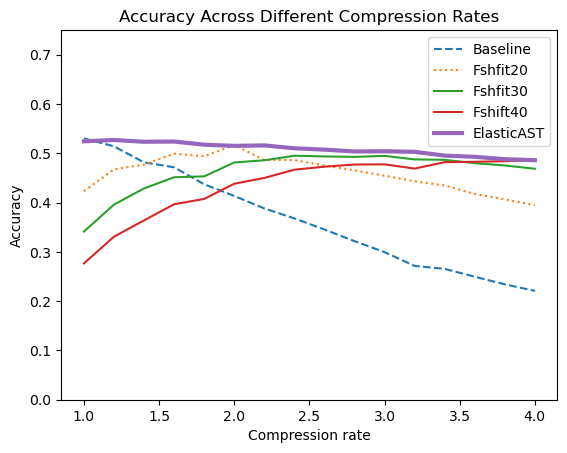

In [6]:
# draw the plot
import matplotlib.pyplot as plt

plt.plot(quality_ratio, baseline, label="Baseline",linestyle='--')
plt.plot(quality_ratio, Fshfit20, label="Fshfit20",linestyle=':')
plt.plot(quality_ratio, Fshift30, label="Fshfit30",linestyle='-')
plt.plot(quality_ratio, Fshift40, label="Fshift40",linestyle='-')
plt.plot(quality_ratio, elastic_ast, label="ElasticAST",linewidth=3)

plt.legend()
plt.xlabel("Compression rate")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Different Compression Rates")
# show grid

# set y-axis range
plt.ylim(0.0, 0.75)

plt.show()